In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from tqdm import tqdm

In [2]:
def train_evaluate(model, train_loader, test_loader, optimizer, criterion, device, epochs):
    train_losses, test_accuracies = [], []
    all_preds, all_labels = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
        # Avaliação
        model.eval()
        correct, total = 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(images.size(0), -1).to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        test_accuracies.append(100 * correct / total)
    return train_losses, test_accuracies, all_preds, all_labels

In [9]:
class MLPExp(nn.Module):
    def __init__(
          self, input_size, hidden_layers,
          num_classes, activation_fn=nn.ReLU(), dropout=0.0):
        super().__init__()
        layers = []
        in_features = input_size
        for hidden_units in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(activation_fn)
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_features = hidden_units
        layers.append(nn.Linear(in_features, num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

In [4]:
transform_default = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_ds1 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_default)
train_ds2 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_augmented)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_default)

100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s]


## 🔬 Experimento 1

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = MLPExp(32*32*3, [128, 64], 10, activation_fn=nn.ReLU(), dropout=0.3).to(device)
train_loader1 = torch.utils.data.DataLoader(train_ds1, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
train_losses1, test_acc1, preds1, labels1 = train_evaluate(model1, train_loader1, test_loader, optimizer1, criterion, device, 20)

KeyboardInterrupt: 

## 🔬 Experimento 2

In [6]:
model2 = MLPExp(32*32*3, [256, 128, 64], 10, activation_fn=nn.Tanh(), dropout=0.2).to(device)
train_loader2 = torch.utils.data.DataLoader(train_ds2, batch_size=128, shuffle=True)
optimizer2 = optim.SGD(model2.parameters(), lr=0.0005, weight_decay=0.001, momentum=0.9)
train_losses2, test_acc2, preds2, labels2 = train_evaluate(model2, train_loader2, test_loader, optimizer2, criterion, device, 20)

## 📈 Resultados e Visualização

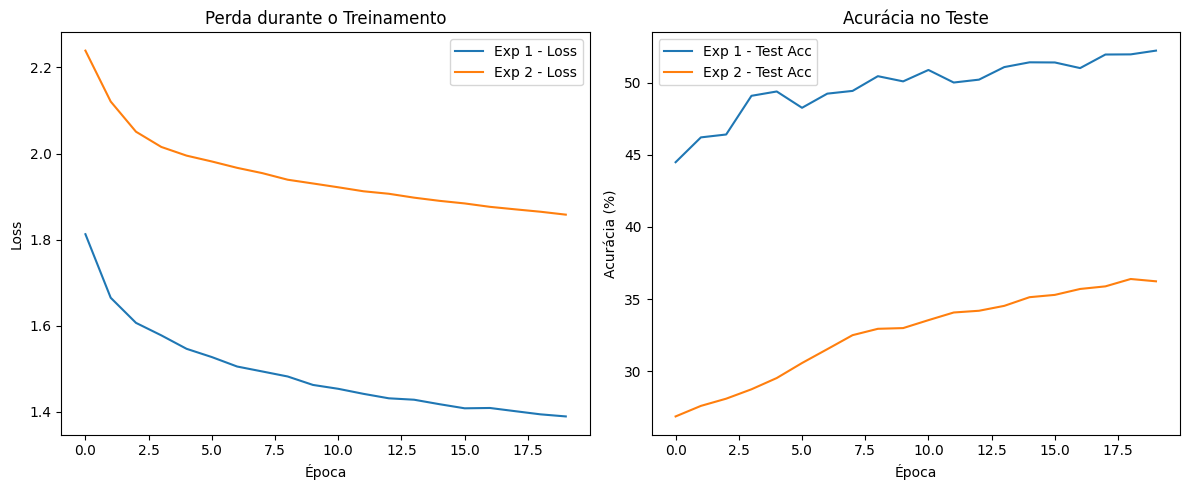

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses1, label='Exp 1 - Loss')
plt.plot(train_losses2, label='Exp 2 - Loss')
plt.title('Perda durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_acc1, label='Exp 1 - Test Acc')
plt.plot(test_acc2, label='Exp 2 - Test Acc')
plt.title('Acurácia no Teste')
plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
print('Experimento 1')
print(classification_report(labels1, preds1, target_names=test_ds.classes))

print('Experimento 2')
print(classification_report(labels2, preds2, target_names=test_ds.classes))

Experimento 1
              precision    recall  f1-score   support

    airplane       0.53      0.65      0.58      1000
  automobile       0.60      0.65      0.62      1000
        bird       0.48      0.27      0.35      1000
         cat       0.37      0.35      0.36      1000
        deer       0.43      0.51      0.47      1000
         dog       0.43      0.40      0.42      1000
        frog       0.56      0.62      0.59      1000
       horse       0.58      0.61      0.59      1000
        ship       0.63      0.62      0.63      1000
       truck       0.58      0.55      0.56      1000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.52     10000
weighted avg       0.52      0.52      0.52     10000

Experimento 2
              precision    recall  f1-score   support

    airplane       0.45      0.39      0.42      1000
  automobile       0.38      0.40      0.39      1000
        bird       0.27      0.08      0.12      1